In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
from scipy.stats import spearmanr
from sklearn.mixture import GaussianMixture
from scipy.stats import norm


from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis
['/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis', '/home/admin-u6015325/anaconda3/lib/python37.zip', '/home/admin-u6015325/anaconda3/lib/python3.7', '/home/admin-u6015325/anaconda3/lib/python3.7/lib-dynload', '', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/strkernel-0.2-py3.7.egg', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/admin-u6015325/.ipython', '/home/admin-u6015325/ownCloud/git/SynbioML']


In [2]:
folder_path = '../../data/pipeline_data/'

path_e1 = folder_path + 'Results_e1.csv'

df_e1 = pd.read_csv(path_e1)

In [3]:
colors = sns.color_palette("tab10")

In [4]:
def hist(df, title = 'Hist'):
    df_bandits = df.loc[df['Group'].isin(['Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3', 'UNI'])]
    sns.histplot(data = df_bandits, x = 'AVERAGE', hue = 'Group', kde=True)
    plt.title(title)
    print('mean:')
    print(df_bandits.groupby('Group').mean())
    print('0.9 quantile')
    print(df_bandits.groupby('Group').quantile(0.9))

In [5]:
def mixture_fit(df, title = 'mixture fit'):
    df_bandits = df.loc[df['Group'].isin(['Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3', 'UNI'])]
    
    means1 = []
    stds1 = []
    means2 = []
    stds2 = []
    group_names = df_bandits['Group'].unique()
    
    for group in group_names:
        df_group = df.loc[df['Group'] == group]
        
        data = np.asarray(df_group['AVERAGE']).reshape(len(df_group),1)
        gm = GaussianMixture(n_components=2, random_state=0).fit(data)
        if gm.means_[0,0] <= gm.means_[1,0]:
            mean1 = gm.means_[0,0]
            std1 = np.sqrt(gm.covariances_[0,0,0])
            mean2 = gm.means_[1,0]
            std2 = np.sqrt(gm.covariances_[1,0,0])
        else:
            mean2 = gm.means_[0,0]
            std2 = np.sqrt(gm.covariances_[0,0,0])
            mean1 = gm.means_[1,0]
            std1 = np.sqrt(gm.covariances_[1,0,0])
            
        means1.append(mean1)
        stds1.append(std1)
        means2.append(mean2)
        stds2.append(std2)
        
    fig, axes = plt.subplots(1,2, figsize = (15,5))
    x = np.linspace(0,1.5, 100)
#     import colormaps as cmaps
#     plt.register_cmap(name='viridis', cmap=cmaps.viridis)
#     plt.set_cmap(cmaps.viridis)
    for i in range(len(means1)):
        axes[0].plot(x, norm.pdf(x, loc = means1[i], scale = stds1[i]), alpha=0.6, label= group_names[i], color = colors[i])
        axes[1].plot(x, norm.pdf(x, loc = means2[i], scale = stds2[i]), alpha=0.6, label= group_names[i], color = colors[i])
        axes[0].legend()
        axes[0].set_title(title + ' left')
        axes[1].legend()
        axes[1].set_title(title + ' right')
    
    plt.show()

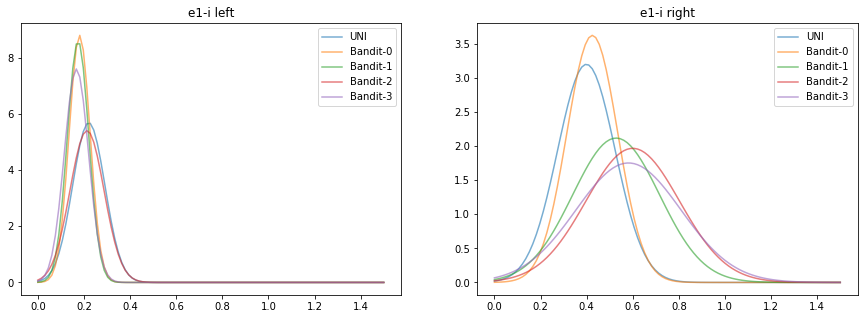

In [6]:
mixture_fit(df_e1, 'e1-i')

# Quantile line plot

In [7]:
def quant_line(df, title = 'Hist'):
    quantile_levels = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
    df_bandits = df.loc[df['Group'].isin(['UNI', 'Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])]
#     sns.histplot(data = df_bandits, x = 'AVERAGE', hue = 'Group', kde=True)
#     plt.title(title)
#     print('mean:')
#     print(df_bandits.groupby('Group').mean())
#     print('0.9 quantile')
#     print(df_bandits.groupby('Group').quantile(0.9))
    for quant in quantile_levels:
        plt.plot(df_bandits.groupby('Group')['AVERAGE'].quantile(quant), marker = '.', label = str(quant), alpha = 0.6)
    plt.legend()
    plt.title(title + ' Quantile of groups')

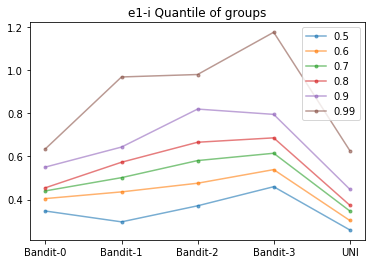

In [8]:
quant_line(df_e1, 'e1-i')